In [1]:
import torch
print(f"torch: {torch.__version__}")
import torchvision
print(f"torchvisio: {torchvision.__version__}")
import torchaudio
print(f"torchaudio: {torchaudio.__version__}")
import torchtext
print(f"torchtext: {torchtext.__version__}")
import torchdata
print(f"torchdata: {torchdata.__version__}")

torch: 1.13.0
torchvisio: 0.14.0
torchaudio: 0.13.0
torchtext: 0.14.0
torchdata: 0.5.1


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import random

import torchvision
import torchvision.transforms as transforms

from src.utils.optim.schedulers import CosineWarmup
from src.models.sequence.rnns.rnn import RNN


import os
import argparse
from tqdm.auto import tqdm


# import wandb
# wandb.login()

In [14]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device available now:', device)

if device == 'cuda':
    cudnn.benchmark = True

Device available now: cpu


## Defining functions

### Hyperparameters

In [15]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# Dataset
parser.add_argument('--dataset', default='cifar10', choices=['cifar10', 'listops', 'imdb', 'aan', 'pathfinder'], type=str, help='Dataset')
###! imdb refers to TEXT, ann refers to RETRIEVAL 
parser.add_argument('--grayscale', action='store_true', help='Use grayscale CIFAR10')


# Dataloader
parser.add_argument('--num_workers', default=0, type=int, help='Number of workers to use for dataloader')
parser.add_argument('--batch_size', default=50, type=int, help='Batch size')


# Optimizer
parser.add_argument('--lr', default= 0.01, type=float, help='Learning rate') # 0.01
parser.add_argument('--lr_factor', default= 0.25, type=float, help='Factor of Learning rate') 
parser.add_argument('--weight_decay', default=0.05, type=float, help='Weight decay')



# Scheduler
parser.add_argument('--epochs', default=200, type=float, help='Training epochs')


# Model
parser.add_argument('--n_layers', default=2, type=int, help='Number of layers') #6
parser.add_argument('--d_model', default=128, type=int, help='Model dimension') #512
parser.add_argument('--d_hidden', default=196, type=int, help='Hidden (state) dimension ') #384
parser.add_argument('--dropout', default=0.1, type=float, help='Dropout')
parser.add_argument('--prenorm', action='store_false', help='Prenorm')
parser.add_argument('--norm', default= 'BN', choices=['LN', 'BN'], help='Norm types')
parser.add_argument('--cell', default= 'rnn', type=str, help='RNN\'s cell')


# General
parser.add_argument('--resume', '-r', action='store_true', help='Resume from checkpoint')

# args = parser.parse_args()
args, unknown = parser.parse_known_args()

In [18]:
print(args)

Namespace(batch_size=50, cell='rnn', d_hidden=196, d_model=128, dataset='cifar10', dropout=0.1, epochs=200, grayscale=False, lr=0.01, lr_factor=0.25, n_layers=2, norm='BN', num_workers=0, prenorm=True, resume=False, weight_decay=0.05)


In [19]:
# d = RNN(d_input = 3, d_model = 5, lr = args.lr * args.lr_factor, cell = "rnn", return_output=True, transposed=False, dropout=0)

In [20]:
# for i in d.parameters():
#     print(i._optim)

### Datasets

In [21]:
def split_train_val(train, val_split):
    train_len = int(len(train) * (1.0-val_split))
    train, val = torch.utils.data.random_split(
        train,
        (train_len, len(train) - train_len),
        generator=torch.Generator().manual_seed(42),
    )
    return train, val

In [22]:
if args.dataset == 'cifar10':
    if args.grayscale:
        transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean=122.6 / 255.0, std=61.0 / 255.0),
            transforms.Lambda(lambda x: x.view(1, 1024).t())
        ])
    else:
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            transforms.Lambda(lambda x: x.view(3, 1024).t())
        ])
    
    # S4 is trained on sequences with no data augmentation!
    transform_train = transform_test = transform

    trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar/', train=True, download=True, transform=transform_train)
    trainset, _ = split_train_val(trainset, val_split=0.1)

    valset = torchvision.datasets.CIFAR10(
        root='./data/cifar/', train=True, download=True, transform=transform_test)
    _, valset = split_train_val(valset, val_split=0.1)

    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar/', train=False, download=True, transform=transform_test)

    d_input = 3 if not args.grayscale else 1
    d_output = 10

else: raise NotImplementedError

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [23]:
# Dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)


In [24]:
# Taking a single batch of the images
images, labels = next(iter(trainloader))
print(images.size(), labels)

torch.Size([50, 1024, 3]) tensor([8, 0, 7, 9, 3, 1, 3, 0, 1, 3, 4, 3, 4, 7, 6, 7, 1, 1, 4, 7, 3, 1, 9, 8,
        7, 9, 0, 8, 8, 5, 5, 9, 3, 5, 4, 5, 9, 3, 2, 3, 6, 5, 8, 4, 0, 0, 9, 7,
        1, 9])


In [25]:
len(trainset)

45000

In [26]:
images

tensor([[[ 0.3817,  0.6104,  1.3880],
         [ 0.4205,  0.6498,  1.4270],
         [ 0.4205,  0.6498,  1.4270],
         ...,
         [-1.3823, -1.1399, -0.8362],
         [-1.4017, -1.1792, -0.8167],
         [-0.8007, -0.5892, -0.2118]],

        [[ 1.1378,  1.7511,  2.3830],
         [ 0.9827,  1.6528,  2.2660],
         [ 0.9439,  1.6331,  2.2660],
         ...,
         [-1.7118, -2.1429, -1.6556],
         [-1.6924, -2.1233, -1.5971],
         [-1.6924, -2.1233, -1.7141]],

        [[-0.0835,  1.1611,  2.1684],
         [-0.0835,  1.1414,  2.1489],
         [-0.0641,  1.1808,  2.1879],
         ...,
         [ 0.9439,  0.8464,  0.3149],
         [ 1.0021,  0.9054,  0.3930],
         [ 1.1184,  0.9644,  0.4710]],

        ...,

        [[-0.8977,  0.4138,  1.8953],
         [-0.8783,  0.4334,  1.9538],
         [-0.8783,  0.4334,  1.9733],
         ...,
         [ 1.4867, -0.2352, -0.9727],
         [ 1.4673, -0.2942, -1.0898],
         [ 1.4867, -0.2549, -1.1093]],

        [[

In [27]:
len(trainset), len(trainloader)

(45000, 900)

### Model architecture

In [28]:
class RNNbased(nn.Module):

    def __init__(
        self,
        d_input,
        d_output,
        lr,
        cell='rnn',
        d_model=256,
        d_hidden=128,
        n_layers=2,
        dropout=0.2,
        prenorm=True,
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB) (like embedding layer)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.FFNs = nn.ModuleList()

        for _ in range(n_layers):
            self.layers.append(
                RNN(d_input = d_model, d_model = d_hidden, lr = lr, cell = cell, return_output=True, transposed=True, dropout=0)
            )
            # self.norms.append(nn.LayerNorm(d_model))
            self.norms.append(nn.BatchNorm1d(d_model)) 
            self.dropouts.append(nn.Dropout1d(dropout))
            self.FFNs.append(nn.Sequential(nn.Conv1d(d_hidden, d_model*2, kernel_size= 1 ), nn.GLU(dim=-2))  #                
                                 )

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        

        for layer, norm, dropout, FFN in zip(self.layers, self.norms, self.dropouts, self.FFNs):
            ''' Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L) '''

            
            z = x #(B, d_model, L) -> (B, d_model, L) 
            if self.prenorm:
                # Prenorm (BN)
                z = norm(z) # (B, d_model, L) -> (B, d_model, L) 

            # Apply recurrence: we ignore the state input and output
            z, _ = layer(z) #(B, d_model, L) -> (B, d_model, L) (note that we transpose the input inside the layer)

            
            # Dropout on the output of the MLP 
            z = dropout(z) #(B, d_model, L) -> (B, d_model, L) for dropout1d
            
            # MLP +GLP
            z = FFN(z) #(B, d_model, L) -> (B, d_model, L) for conv1d

            # Residual connection
            x = z + x  #(B, d_model, L) -> (B, d_model, L)

            if not self.prenorm:
                # Post-norm (BN)
                x = norm(x) #(B, d_model, L) -> (B, d_model, L)
                
        # Pooling: average pooling over the sequence length
        x = x.transpose(-1, -2)
        x = x.mean(dim=1) # (B, L, d_model) -> (B, d_model)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x

In [32]:
example = RNNbased(d_input=d_input, 
                   d_output=d_output, 
                   cell='rnn',
                   lr = args.lr * args.lr_factor,
                   d_model=args.d_model, 
                   d_hidden=args.d_hidden, 
                   n_layers=args.n_layers, 
                   dropout=args.dropout, 
                   prenorm=args.prenorm)
print(example)

RNNbased(
  (encoder): Linear(in_features=3, out_features=128, bias=True)
  (layers): ModuleList(
    (0): RNN(
      (cell): RNNCell(
        (W_hx): Linear(in_features=128, out_features=196, bias=False)
        (activate): Tanh()
        (W_hh): Linear(in_features=196, out_features=196, bias=False)
      )
    )
    (1): RNN(
      (cell): RNNCell(
        (W_hx): Linear(in_features=128, out_features=196, bias=False)
        (activate): Tanh()
        (W_hh): Linear(in_features=196, out_features=196, bias=False)
      )
    )
  )
  (norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropouts): ModuleList(
    (0): Dropout1d(p=0.1, inplace=False)
    (1): Dropout1d(p=0.1, inplace=False)
  )
  (FFNs): ModuleList(
    (0): Sequential(
      (0): Conv1d(196, 256, kernel_size=(1,), stride=(1,))
      (1): GLU(dim=-2)
    )
    (1): Seq

In [33]:
def setup_optimizer(model, lr, weight_decay, epochs):
    # All parameters in the model
    all_parameters = list(model.parameters())

    # General parameters don't contain the special _optim key
    params = [p for p in all_parameters if not hasattr(p, "_optim")]

    # Create an optimizer with the general parameters
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)

    # Add parameters with special hyperparameters
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
        # e.g., p could be {'weight_decay': 0.0, 'lr': 1e-07}
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts 
    
    
    for hp in hps: 
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp] ## select parameter matrices that have "_optim" and assign "_optim = None" to matrices that do not have
        optimizer.add_param_group(
            {"params": params, **hp} ## <**hp> referes to hyperparameters e.g., {'weight_decay': 0.0}
        )

    # Create a lr scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.2)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
    scheduler = CosineWarmup(optimizer, T_max = epochs, eta_min= 1e-7, warmup_step= int(epochs * 0.1) + 1) 

    ''' Print optimizer info '''
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    
    
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

In [34]:
# example
optimizer, scheduler = setup_optimizer(
    example, lr=args.lr, weight_decay=args.weight_decay, epochs=args.epochs
)

Optimizer group 0 | 12 tensors | lr 0.0004761904761904762 | weight_decay 0.05
Optimizer group 1 | 4 tensors | lr 0.00011904761904761905 | weight_decay 0.0


In [35]:
scheduler

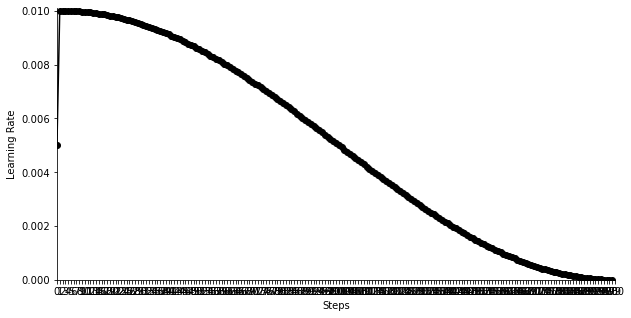

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

LEARNING_RATE = args.lr
EPOCHS = args.epochs
STEPS_IN_EPOCH = 1

# Set model and optimizer
model = torch.nn.Linear(2, 1)
optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay= args.weight_decay)

# Define your scheduler here as described above
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)
scheduler = CosineWarmup(optimizer, T_max = args.epochs, eta_min= 1e-7, warmup_step= 2) 

# Get learning rates as each training step
learning_rates = []

for i in range(EPOCHS*STEPS_IN_EPOCH):
    optimizer.step()
    learning_rates.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

# Visualize learinig rate scheduler
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(range(EPOCHS*STEPS_IN_EPOCH), 
        learning_rates,
        marker='o', 
        color='black')
ax.set_xlim([0, EPOCHS*STEPS_IN_EPOCH])
ax.set_ylim([0, LEARNING_RATE + 0.0001])
ax.set_xlabel('Steps')
ax.set_ylabel('Learning Rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(STEPS_IN_EPOCH))
ax.xaxis.set_minor_locator(MultipleLocator(1))
plt.show()

In [39]:
5e-3

0.005

In [40]:
1e-3 * 0.25

0.00025

In [ ]:
0.005

### Training

In [19]:
# Training
def train(model, optimizer,  criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    print_every = 50

    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        wandb.log({"Train/Batch loss": train_loss/(batch_idx+1)})

        if (batch_idx % print_every) == 0:
            print(f"Batch: {batch_idx}, Avg: {train_loss/(batch_idx+1)}")
        
        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
            (batch_idx, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total)
        )
    return train_loss/(batch_idx+1)



def eval(model, criterion, dataloader):
    global best_acc
    model.eval()
    eval_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f | Acc: %.3f%% (%d/%d)' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1), 100.*correct/total, correct, total)
            )
            
        return 100.*correct/total

Loss

In [20]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
run_id = wandb.util.generate_id()
CHECKPOINT_PATH = f'./checkpoint/checkpoint_{run_id}.pth'
print(CHECKPOINT_PATH)

./checkpoint/checkpoint_5pmj4d8b.pth


In [21]:
total_runs = 1
for run in range(total_runs):
    wandb.init(
        id= run_id,
        project="test", 
        # Model + Cell + Run
        name=f"RNN_Vanilla_{run}", 
        config=args,
        resume = 'allow')
    
    # defining model (resume or not)
    if not wandb.run.resumed:
        print('==> Building model / ...')
        model = RNNbased(d_input=d_input, 
                    d_output=d_output, 
                    lr = args.lr * args.lr_factor,
                    cell='rnn',
                    d_model=args.d_model, 
                    d_hidden=args.d_hidden, 
                    n_layers=args.n_layers, 
                    dropout=args.dropout, 
                    prenorm=args.prenorm)
        
        optimizer, scheduler = setup_optimizer(model, lr=args.lr, weight_decay=args.weight_decay, epochs=args.epochs)
        # optimizer = optim.AdamW(model.parameters(), lr= args.lr, weight_decay= args.weight_decay)
        # scheduler = CosineWarmup(optimizer, T_max = args.epochs, eta_min= 1e-7, warmup_step= int(args.epochs * 0.1) + 1) 
        
    else:
        print('==> Resuming from checkpoint...')
        checkpoint = torch.load(CHECKPOINT_PATH) #not use wandb.restore('checkpoint.tar') because of encoding error
        
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
        
    model = model.to(device)

    

    ## defining training, validating and testing
    pbar = tqdm(range(start_epoch, args.epochs))
    for epoch in pbar:
        wandb.log({"Epoch": epoch, "lr_general": scheduler.get_last_lr()[0]}) #record general lr for the current lr
        wandb.log({"Epoch": epoch, "lr_special": scheduler.get_last_lr()[1]}) #record special lr for the current lr
        
        if epoch == 0:
            pbar.set_description('Epoch: %d' % (epoch))
        else:
            pbar.set_description('Epoch: %d | Val acc: %1.3f' % (epoch, val_acc))


        print('==> Training...')
        epoch_loss = train(model = model,optimizer = optimizer, criterion = nn.CrossEntropyLoss())
        wandb.log({"Epoch": epoch, "Train/Epoch Loss": epoch_loss})


        print('==> Validating...')
        val_acc = eval(model = model, criterion = nn.CrossEntropyLoss(), dataloader = valloader)
        wandb.log({"Epoch": epoch, "Val/Val acc": val_acc})
        
        scheduler.step() #update lr
        
        #Save checkpoints
        if val_acc > best_acc:
            state = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(), # record lr for the next epoch
                'acc': val_acc,
                'epoch': epoch,

            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
                
            torch.save(state, CHECKPOINT_PATH)
            # wandb.save(CHECKPOINT_PATH)
            best_acc = val_acc
    
    print('==> Testing...')
    test_acc = eval(model = model, criterion = nn.CrossEntropyLoss(), dataloader = testloader)
    wandb.log({"Test/Test acc": test_acc})
    
    # Mark the run as finished
    wandb.finish()

==> Building model / ...
Optimizer group 0 | 12 tensors | lr 0.0004761904761904762 | weight_decay 0.05
Optimizer group 1 | 4 tensors | lr 0.00011904761904761905 | weight_decay 0.0


Epoch: 0:   0%|          | 0/200 [00:00<?, ?it/s]

==> Training...


Batch: 0, Avg: 2.418267011642456


Batch: 50, Avg: 2.1103724848990346


Batch: 100, Avg: 2.0617622266901603


Batch Idx: (137/900) | Loss: 2.045 | Acc: 23.232% (1603/6900): : 138it [06:23,  2.78s/it]
Epoch: 0:   0%|          | 0/200 [06:23<?, ?it/s]


KeyboardInterrupt: 